# Fit fixed noise – fit noise parameters for selected seasons

Use selected ranges of dates to denoise and fit noise parameters.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
import scipy

import rtrend_tools.data_io as dio
import rtrend_tools.preprocessing as preproc
from rtrend_tools.utils import map_parallel_or_sequential
import rtrend_tools.visualization as vis


%matplotlib notebook
mpl.rcParams['pdf.fonttype'] = 42  # Make text editable


ModuleNotFoundError: No module named 'rtrend_tools'

<IPython.core.display.Javascript object>


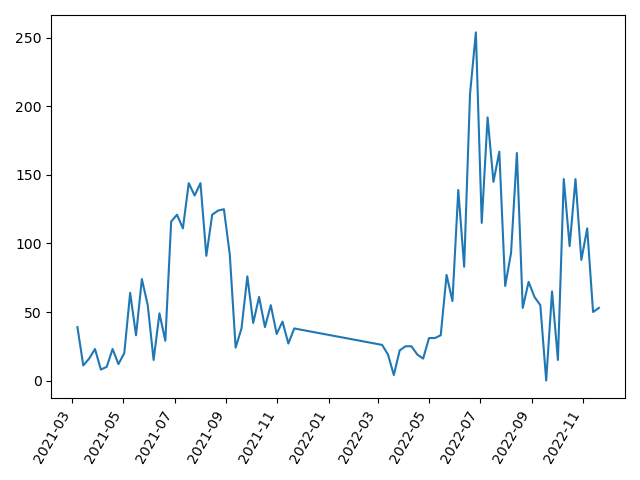

In [6]:
# IMPORT MOSQUITO DATA
# --------------------

species = "Ae_aegypti"
cutoff_vals = np.arange(0.02, 0.81, 0.01)

# --------------

# # -()- Miami – Any
# mosq_fname = "mosquito_data/Miami_week.csv"
# use_roi_edges = [
#     ("2019-02-01", "2019-11-25"), 
#     ("2020-03-01", "2020-11-25"),
#     ("2022-03-01", "2021-11-25"),
# #     ("2022-03-01", "2022-11-25"),
# ]  # List of (start, end) tuples
# out_fname = "noise_data/Miami/params_2019-2020-2021.csv"

# # -()- Miami – 2021-2022
# mosq_fname = "mosquito_data/Miami_week.csv"
# use_roi_edges = [
#     ("2021-02-01", "2021-11-25"), 
#     ("2022-03-01", "2022-11-25"),
# ]  # List of (start, end) tuples
# out_fname = "noise_data/Miami/params_2021-2022.csv"

# # -()- Maricopa
# mosq_fname = "mosquito_data/Maricopa_week.csv"
# use_roi_edges = [
# #     ("2014-05-22", "2014-11-25"), 
# #     ("2015-05-22", "2015-11-25"), 
# #     ("2016-05-22", "2016-12-06"),   # Troublesome
# #     ("2017-05-22", "2017-11-25"), 
#     ("2018-05-22", "2018-12-16"), 
#     ("2019-05-22", "2019-12-16"), 
#     ("2020-05-22", "2020-12-16"), 
# #     ("2021-05-22", "2021-12-16"), 
# ]
# out_fname = "noise_data/Maricopa/params_2018-2020.csv"

# # -()- Key West
# mosq_fname = "mosquito_data/Key_West_week.csv"
# loc_name = "Key_West"
# use_roi_edges = [
#     ("2011-05-01", "2011-11-15"),
#     ("2012-05-01", "2012-11-15"), 
#     ("2013-05-01", "2013-11-15"),
#     ("2014-05-01", "2014-11-15"),
# #     ("2015-05-01", "2015-11-15"),  # Trouble
#     ("2016-05-01", "2016-11-15"),
#     ("2017-05-01", "2017-11-15"),
#     ("2018-05-01", "2018-11-15"),
#     ("2019-05-01", "2019-11-15"),
# #     ("2020-05-01", "2020-11-15"),
# ]
# # out_fname = f"noise_data/{loc_name}/params_2012-to-2014.csv"
# out_fname = f"noise_data/{loc_name}/params_2011-2012-2013-2014-2016-2017-2018-2019.csv"

# # -()- Los Angeles – 2018-2019
# mosq_fname = "mosquito_data/LA_week.csv"
# use_roi_edges = [
#     ("2018-07-01", "2018-11-15"), 
#     ("2019-07-01", "2019-11-15"),
#     ("2020-07-01", "2020-11-15"),
# ]
# out_fname = "noise_data/Los_Angeles/params_2018-2019-2020.csv"

# -()- Los Angeles – 2020-2021
mosq_fname = "mosquito_data/LA_week.csv"
use_roi_edges = [
    ("2020-05-15", "2020-11-08"), 
    ("2021-07-08", "2021-11-08"),
]
out_fname = "noise_data/Los_Angeles/params_2020-2021.csv"


# --------------
# Import

mosq_sr = dio.load_mosquito_test_data(mosq_fname).df[species]

# --- View cropped imported data
fig, ax = plt.subplots()

plot_sr = pd.concat([mosq_sr.loc[start:end] for start, end in use_roi_edges])
ax.plot(plot_sr)
vis.rotate_ax_labels(ax)
fig.tight_layout()

<IPython.core.display.Javascript object>


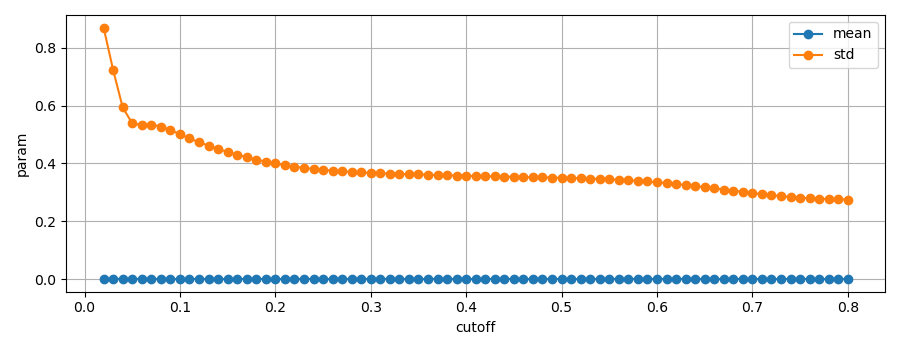

,mean,std
cutoff,,
0.02,0.0,0.870026
0.03,0.0,0.723100
0.04,0.0,0.593959
0.05,0.0,0.538675
0.06,0.0,0.532994
...,...,...
0.76,0.0,0.279668
0.77,0.0,0.278154
0.78,0.0,0.277020


In [7]:
# FIT NOISE TABLE
# ----------------------



# -------
# noise_obj = preproc.NormalMultNoise()
noise_obj = preproc.NormalZeromeanMultNoise()

mean_vals = np.zeros_like(cutoff_vals)
std_vals = np.zeros_like(cutoff_vals)

# Make series that only span through the ROIs
raw_roi_sr = pd.concat([mosq_sr.loc[start:end] for start, end in use_roi_edges])


def fit_noise_single_cutoff(cutoff):
    # Filters the ENTIRE dataset with given cutoff
    denoised_sr = preproc.apply_lowpass_filter_pdseries(mosq_sr, cutoff=cutoff)

    # Crop desired ROIs of the filtered data
    filt_roi_sr = denoised_sr.loc[raw_roi_sr.index]
    
    # Fit noise within all ROIs
    noise_obj.fit(raw_roi_sr, filt_roi_sr)
    
    return [noise_obj.mean, noise_obj.std]
    

noise_params_array = \
    np.array(
        map_parallel_or_sequential(fit_noise_single_cutoff, cutoff_vals, ncpus=1))
#  ^  ^  Signature: mean_vals, std_vals = noise_params_array


# ---------
# Visualize results
params_df = pd.DataFrame(noise_params_array, columns=["mean", "std"], index=cutoff_vals)
params_df.index.name = "cutoff"

fig, ax = plt.subplots(ncols=1, figsize=(9, 3.5))
ax.plot(params_df, "-o", label=params_df.columns)  # Plot params
ax.set_xlabel("cutoff")
ax.set_ylabel("param")
ax.legend()
ax.grid()

fig.tight_layout()


# View as table
params_df

In [8]:
# Export to file
# -------------

do_export = True

# ----
if do_export:
    os.makedirs(os.path.dirname(out_fname), exist_ok=True)
    params_df.to_csv(out_fname, float_format="%0.8f")
    print(f"Exported to {out_fname}")
else:
    print(f"Would have exported to `{out_fname}`")

Exported to noise_data/mia-southbeach/params_2021-2022.csv
